# ST446 Project : Big Data Machine Learning using Spark on Microsoft Azure HDInsight Cluster

##  Abstract:

In this project, the key features and capabilities of Spark's MLlib toolkit are shown using the Airline On-Time Performance Dataset (over 148 million records). The data is split into training and testing set to evaluate the performance of binary classification models to predict if certain flight departures were delayed by 15 mins or not. The weather conditions (e.g. windspeed, humidity, precipitation) at origin and destination airports was integrated with the original airline data-set in order to incorporate the weather features in the models.This notebook is set up on Microsoft Azure HDInsights Spark Cluster using WASB blob storage. We initially run on a 4 worker-node and 2 head node 24-core cluster(D12) and then scale up the number of worker nodes to see change in speed.

# 1. Introduction

Apache Spark is a cluster cpmputing system that provides high-level APIs in Java,Scala and Python. It supports a rich set og higher-level tools for SQL, strudctured data processing. machine learning and graph processing. In this report we focus on its machine learning capabilities using MLib on a pySpark3 kernel. The notebook is set up on Microsoft Azure HDInsight Spark cluster. HDInsight is a fully managed cloud service that enables processing of large amounts of data. 

Resilient Distributed Datasets (RDD) is a fundamental data structure of Spark. It is an immutable distributed collection of objects. Each dataset in RDD is divided into logical partitions, which may be computed on different nodes of the cluster. There are two ways to create RDDs − parallelizing an existing collection in your driver program, or referencing a dataset in an external storage system, such as a shared file system, HDFS, HBase, or any data source offering a Hadoop Input Format. 

##### The figure below shows the iterative operations on Spark RDD. 

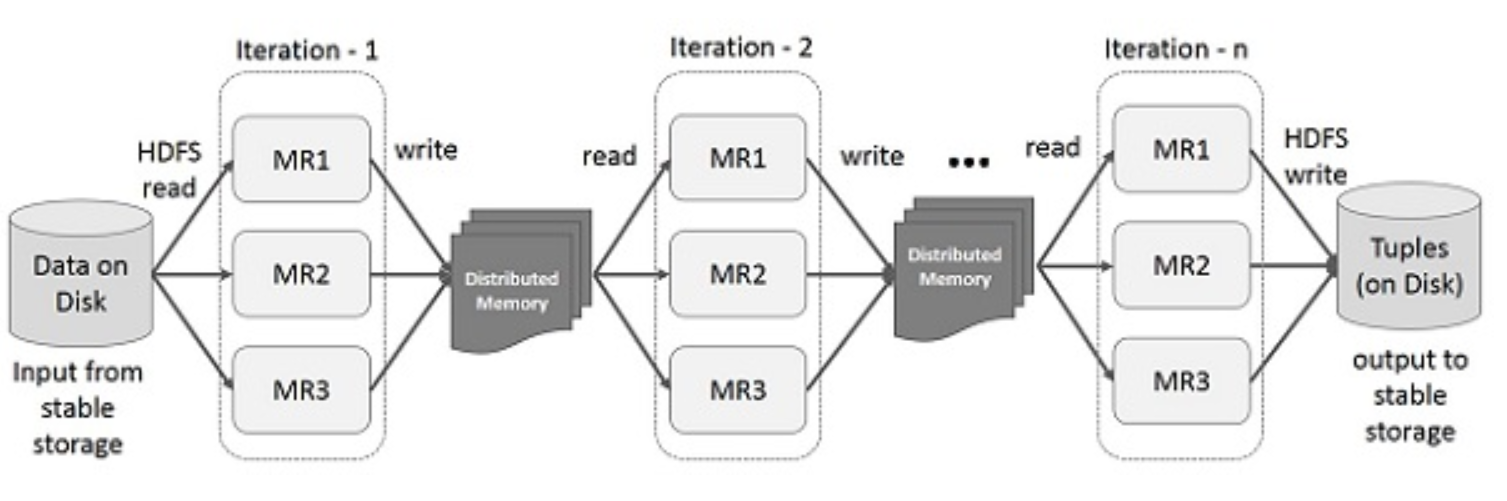

In [1]:
from IPython.display import Image
Image(filename = "Pictures/iterative.PNG")

##### The figure below shows the interactive operations on Spark RDD. 

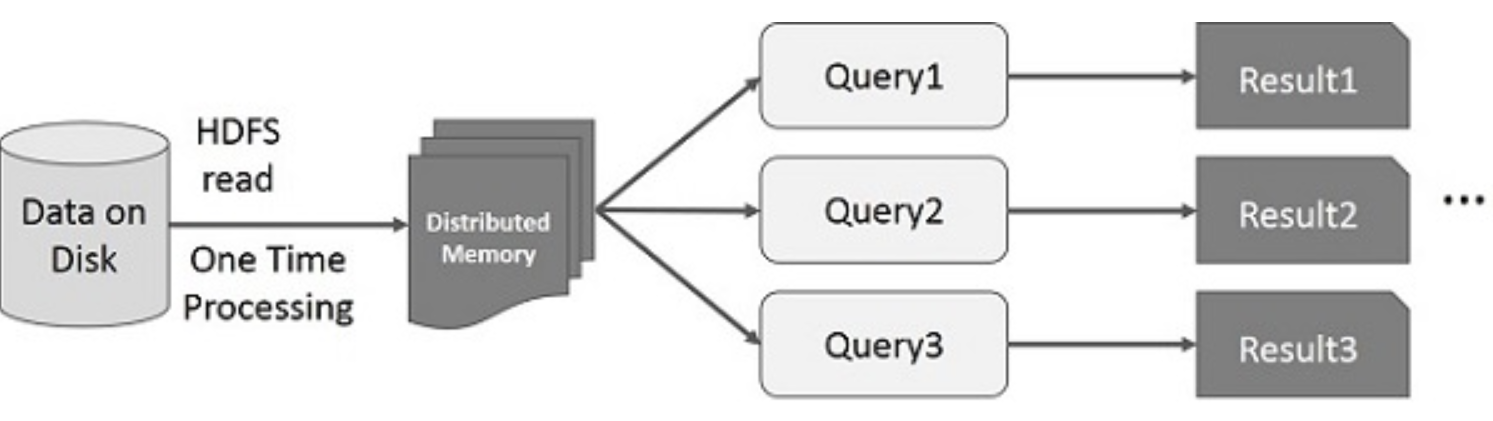

In [2]:
Image(filename = "Pictures/interactive.PNG")

### 1.1 Project Scope:

A binary classification problem is solved where the task is to predict whether flight departures were delayed by 15 mins or not,(1 or 0 repsectively), based on airport (origin and destination airports) and weather (e.g. windspeed, humidity, temperature) features.

The process project is divided into the followig steps:
 - Cluster and Environment Setup
 - Data Preprocessing and Analysis.
 - Modeling 
 - Results 

Through the above steps we highlight Spark SQL, as well as, MLlib's modeling and transformation functions.

### 1.2 Dataset
 
The datasets used include the Airline On-Time Performance Dataset from the Research and Innovative Technology Administration of the Bureau of Transportation Statistics (http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) and the Airport weather data: https://www.ncdc.noaa.gov/. 
The dataset can be obtained from the Revolution Analytics website (http://packages.revolutionanalytics.com/datasets/AirOnTime87to12). 

The dataset was stored on the Microsoft Azure storage blob (WASB). Windows Azure Storage Blob (WASB) is an extension built on top of the HDFS APIs. The Hadoop Distributed File System (HDFS) is one of the core Hadoop components, it is how Hadoop manages data and storage. When a file is loaded into Hadoop the "name node" uses HDFS to partition the file into blocks and it spreads those blocks of data across the worker nodes within the cluster. Each chunk of data is stored on multiple nodes for higher availability. WASB creates a layer of abstraction that enables separation of storage.  

The notation to access data from the blob storage is:  wasb://Container@StorageAccount.blob.core.windows.net/Directory/SubDirectory/File.csv


An interesting feature of the airline data-set is that there are several features (e.g. airport ids, flight numbers etc.) which have many categorical features. The dataset used spans 26 years, 1987 through 2012, and is fairly large: over 148 million records. 


## 2. Cluster and Environment Setup

### 2.1 Spark Cluster setup using Azure HDInsight

A Hadoop cluster consists of several virtual machines (nodes) that are used for distributed processing of tasks. Azure HDInsight handles implementation details of installation and configuration of individual nodes, so only general configuration information have to be provided.

When first creating a cluster, a resource group is either assigned or created to maintain the cluster. In the configuration of the cluster, we use Spark 2.1 on HDInsight 3.6. The cluster is running on Linux OS. 

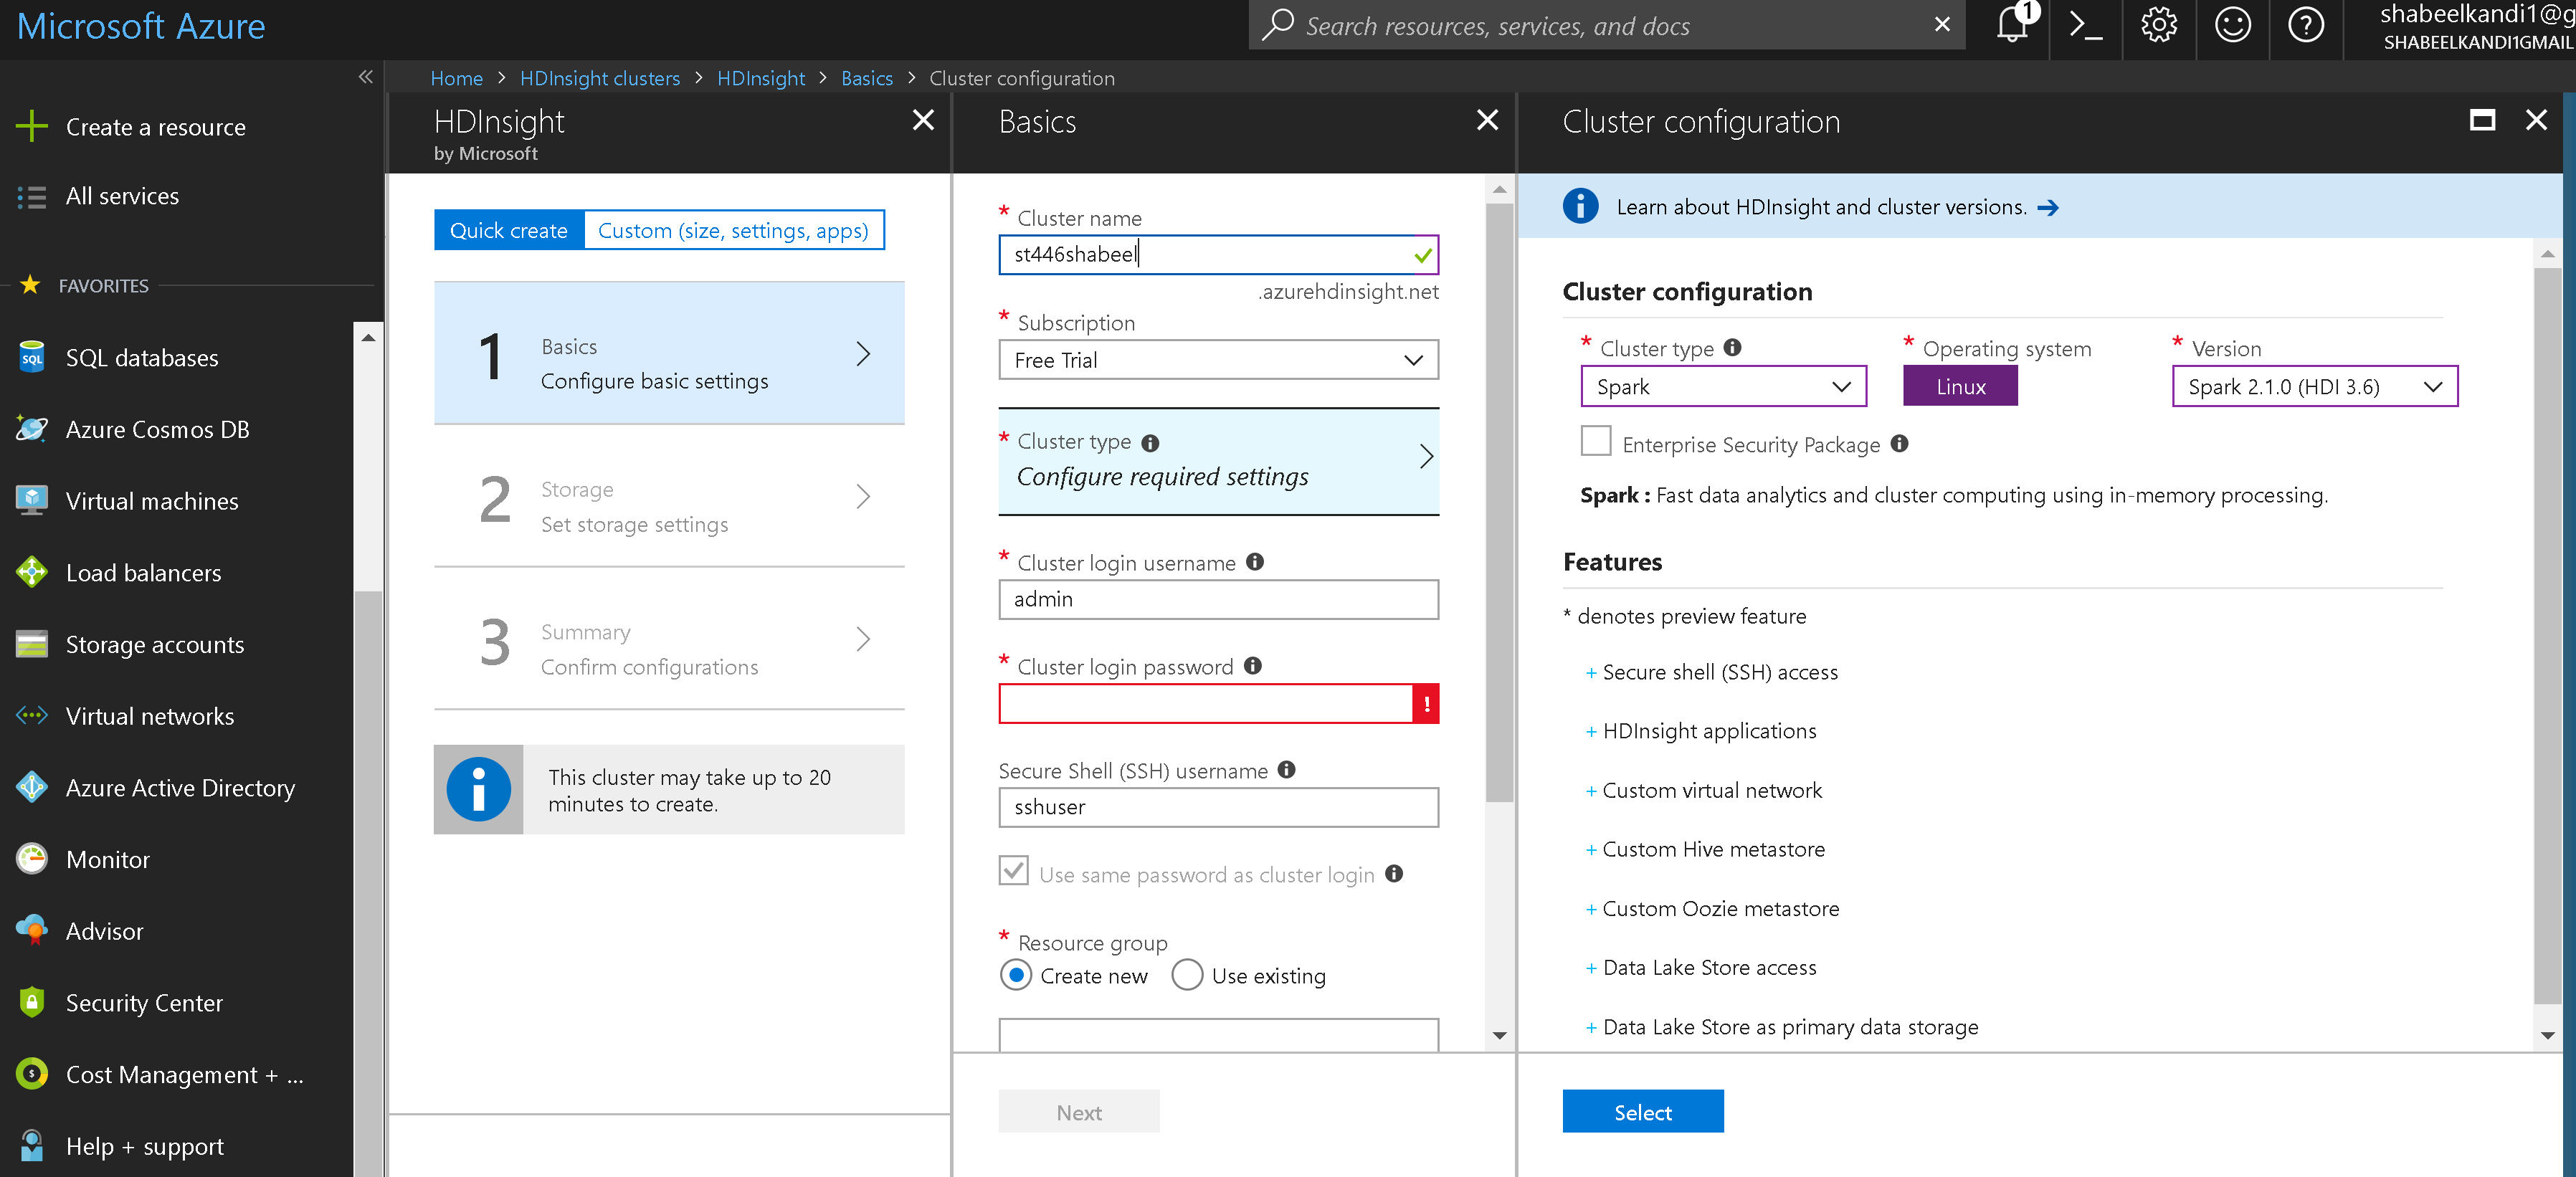

In [1]:
Image(filename = "Pictures/createcluster.PNG")

The storage configuration is set up, which is very straightforward. Windows Storage manager should be downloaded to access the Storage Container and Blob storage for the cluster. When the cluster is deleted, the storage remains with all the files stored intact. The node configurations for the cluster are shown below:

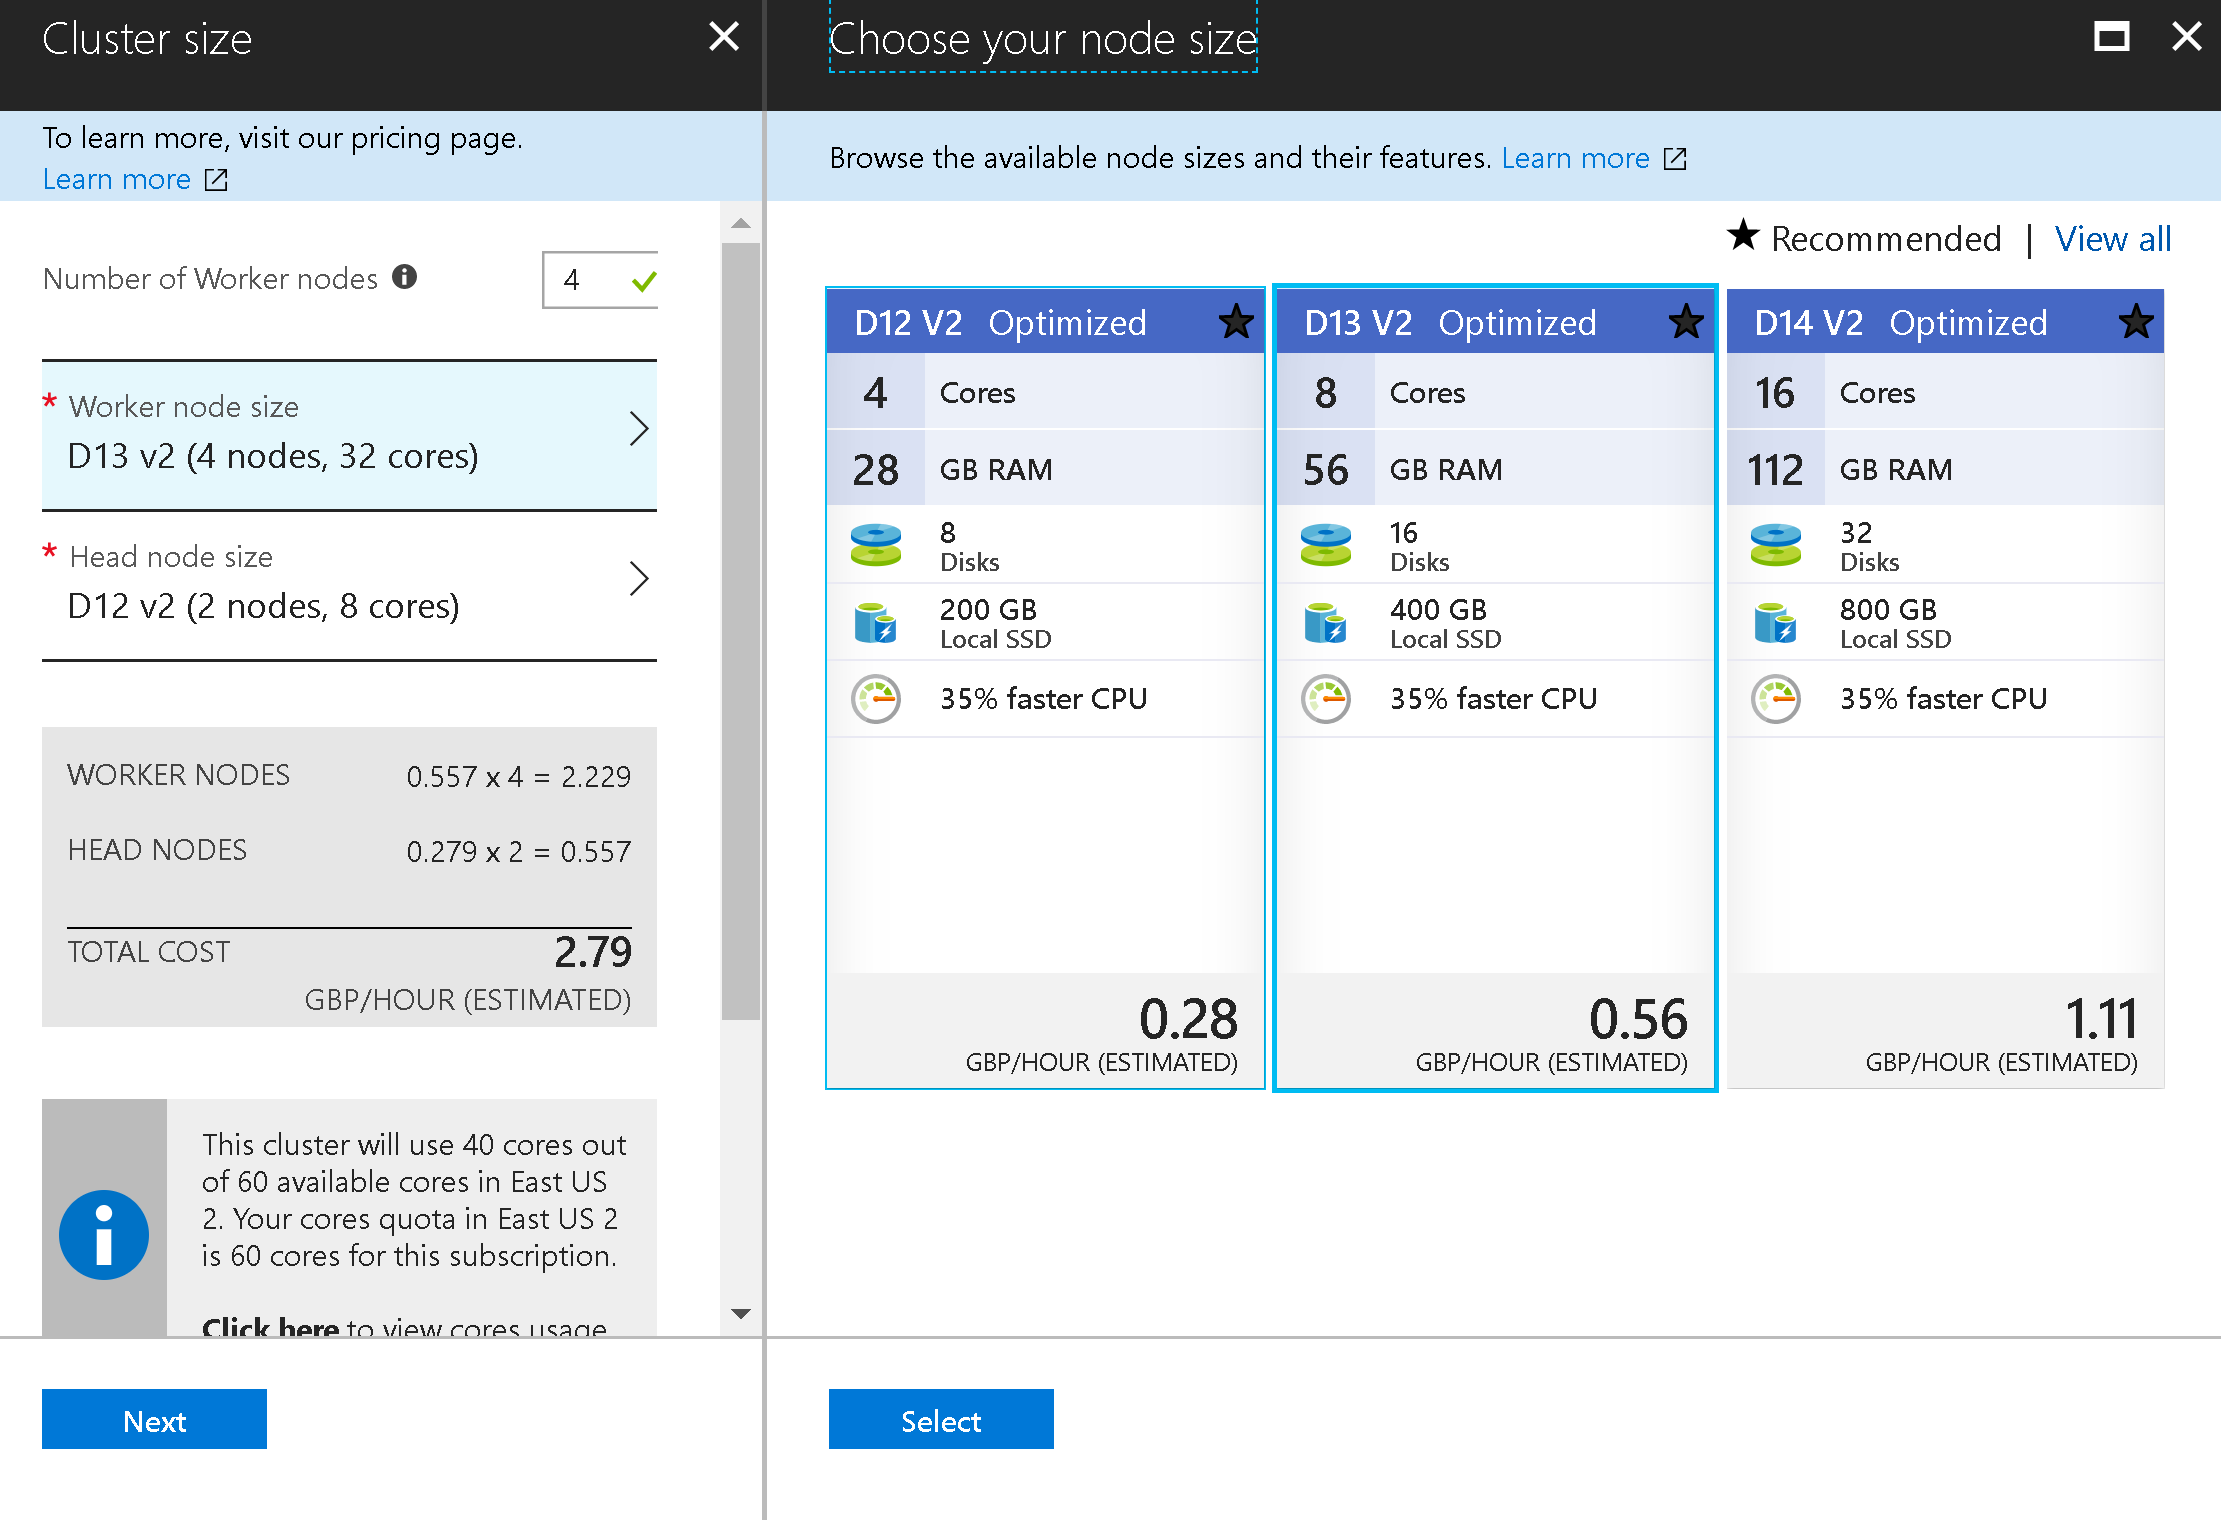

In [2]:
Image(filename = "Pictures/nodes.PNG")

### 2.2 Set file paths

The location of the input data files, test and training data, as well as model location in is set up in the Azure blob storage in the storage container. The blob storage attached to the HDI cluster is referenced as: wasb:/// . The input data files are located on a public Cdssparksamples container. 

In [1]:
#model storage directory path. 
modelDir = "wasb:///user/remoteuser/Airline/Models/"; 

#data storage path. 
dataDir = "wasb:///HdiSamples/HdiSamples/Airline/";

#Location of air dataset:
air_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/Airline/AirlineSubsetCsv"

#location of weather dataset
weather_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/Airline/WeatherSubsetCsv"

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1524775697915_0004,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


## 3. Data Preprocessing and Analysis 


### 3.1 Importing necessary libraries

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime

#setting SQL context
sqlContext = SQLContext(sc)

/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

### 3.2 Data import and cleaning using Spark SQL

In [3]:
#read air data
air = spark.read.csv(path=air_file_loc, header=True, inferSchema=True)

#read weather data
weather = spark.read.csv(path=weather_file_loc, header=True, inferSchema=True)

In [4]:
air.printSchema()
weather.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- UNIQUE_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- DEP_DELAY_NEW: string (nullable = true)
 |-- DEP_DEL15: string (nullable = true)
 |-- DEP_DELAY_GROUP: string (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: 

#### Cleaning Data

In [5]:
#creating temp-tables for the datasets
air.createOrReplaceTempView("airline")
weather.createOrReplaceTempView("weather")

In [6]:
# table with count of number of flights by airport location (origin and location)
spark.sql("SELECT ORIGIN, COUNT(*) as CTORIGIN FROM airline GROUP BY ORIGIN").createOrReplaceTempView("countOrigin")
spark.sql("SELECT DEST, COUNT(*) as CTDEST FROM airline GROUP BY DEST").createOrReplaceTempView("countDest")

#Cleaning data: filter for airports lower than 100 flights
sqlStatement = """SELECT ARR_DEL15 as ArrDel15,  YEAR  as Year,
                  MONTH as Month, DAY_OF_MONTH as DayOfMonth, DAY_OF_WEEK as DayOfWeek,
                  UNIQUE_CARRIER as Carrier, ORIGIN_AIRPORT_ID as OriginAirportID, ORIGIN,
                  DEST_AIRPORT_ID as DestAirportID, DEST, floor(CRS_DEP_TIME/100) as CRSDepTime,
                  floor(CRS_ARR_TIME/100) as CRSArrTime
                  FROM airline
                  WHERE ARR_DEL15 in ('0.0', '1.0')
                  AND ORIGIN IN (SELECT DISTINCT ORIGIN FROM countOrigin where CTORIGIN > 100)
                  AND DEST IN (SELECT DISTINCT DEST FROM countDest where CTDEST > 100) """
airCleaned = spark.sql(sqlStatement)
airCleaned.createOrReplaceTempView("airCleaned")

## grouping weather data
sqlStatement = """SELECT AdjustedYear, AdjustedMonth, AdjustedDay, AdjustedHour, AirportID,
                            avg(Visibility) as Visibility, avg(DryBulbCelsius) as DryBulbCelsius, avg(DewPointCelsius) as DewPointCelsius,
                            avg(RelativeHumidity) as RelativeHumidity, avg(WindSpeed) as WindSpeed, avg(Altimeter) as Altimeter
                            FROM weather
                            GROUP BY AdjustedYear, AdjustedMonth, AdjustedDay, AdjustedHour, AirportID"""
weatherCleaned = spark.sql(sqlStatement)
weatherCleaned.createOrReplaceTempView("weatherCleaned")

### 3.3 Merging Data

The flight data and weather data are merged in the following steps using the time and date of flight and the corresponding weather condition, and the location (Origin and Destination). The null values are removed from the dataset

In [7]:
# Creating joined dataset and removing null values
sqlStatement = """SELECT a.ArrDel15, a.Year, a.Month, a.DayOfMonth, a.DayOfWeek, a.Carrier, a.OriginAirportID, \
                              a.ORIGIN, a.DestAirportID, a.DEST, a.CRSDepTime, b.Visibility as VisibilityOrigin, \
                              b.DryBulbCelsius as DryBulbCelsiusOrigin, b.DewPointCelsius as DewPointCelsiusOrigin,
                              b.RelativeHumidity as RelativeHumidityOrigin, b.WindSpeed as WindSpeedOrigin, \
                              b.Altimeter as AltimeterOrigin, c.Visibility as VisibilityDest, \
                              c.DryBulbCelsius as DryBulbCelsiusDest, c.DewPointCelsius as DewPointCelsiusDest,
                              c.RelativeHumidity as RelativeHumidityDest, c.WindSpeed as WindSpeedDest, \
                              c.Altimeter as AltimeterDest
                              FROM airCleaned a, weatherCleaned b, weatherCleaned c
                              WHERE a.Year = b.AdjustedYear and a.Year = c.AdjustedYear
                              and a.Month = b.AdjustedMonth and a.Month = c.AdjustedMonth
                              and a.DayofMonth = b.AdjustedDay and a.DayofMonth = c.AdjustedDay
                              and a.CRSDepTime= b.AdjustedHour and a.CRSDepTime = c.AdjustedHour
                              and a.OriginAirportID = b.AirportID and a.DestAirportID = c.AirportID"""
joined = spark.sql(sqlStatement).filter("VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL \
                and ORIGIN is not NULL and DEST is not NULL \
                and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and Year is not NULL and Month is not NULL \
                and DayOfMonth is not NULL and DayOfWeek is not NULL and Carrier is not NULL")
joined.createOrReplaceTempView("joined")

In [8]:
# Showing all the tables created so far
spark.sql("show tables").show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |     aircleaned|       true|
|        |        airline|       true|
|        |      countdest|       true|
|        |    countorigin|       true|
|        |         joined|       true|
|        |        weather|       true|
|        | weathercleaned|       true|
+--------+---------------+-----------+

### 3.4 Saving Data on Blob Storage

The final joined dataset now completed in their pre-processing and data cleaining, and are saved as parquet files on the Azure Blob Storage for Analysis. Apache Parquet is a columnar storage format available to any project in the Hadoop ecosystem, regardless of the choice of data processing framework, data model or programming language. 

The final data has the flight data and their respective weather conditions at the time for the flights

In [9]:
# SAVE JOINED DATA IN BLOB
datafilename = dataDir + "Data";
joined.write.mode("overwrite").parquet(datafilename)

## 4. Data exploration and visualization 
----------------------------------


In [10]:
joined_df = spark.read.parquet(datafilename)
joined_df.printSchema()

root
 |-- ArrDel15: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- VisibilityOrigin: double (nullable = true)
 |-- DryBulbCelsiusOrigin: double (nullable = true)
 |-- DewPointCelsiusOrigin: double (nullable = true)
 |-- RelativeHumidityOrigin: double (nullable = true)
 |-- WindSpeedOrigin: double (nullable = true)
 |-- AltimeterOrigin: double (nullable = true)
 |-- VisibilityDest: double (nullable = true)
 |-- DryBulbCelsiusDest: double (nullable = true)
 |-- DewPointCelsiusDest: double (nullable = true)
 |-- RelativeHumidityDest: double (nullable = true)
 |-- WindSpeedDest: double (nullable = true)
 |-

The variable ArrDel15 is the binary classification variable which is 0 if the flight is not late and 1 if the flight is delayed by 15 minutes or more. The other variables are the predictor variables which are used as features of the binary classification model. 

In [11]:
joined.show(1)

+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------------------+-------------+-------------+
|ArrDel15|Year|Month|DayOfMonth|DayOfWeek|Carrier|OriginAirportID|ORIGIN|DestAirportID|DEST|CRSDepTime|VisibilityOrigin|DryBulbCelsiusOrigin|DewPointCelsiusOrigin|RelativeHumidityOrigin|WindSpeedOrigin|AltimeterOrigin|VisibilityDest|DryBulbCelsiusDest|DewPointCelsiusDest|RelativeHumidityDest|WindSpeedDest|AltimeterDest|
+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------------------+-------------+-------------+
|     0.0|2011|    1|         1|  


----------------------------------
### 4.1 Plotting of different variables and features

The different plots show a some of the features being plotted against the ArrDel15 feature which is a binary variable which is 0 if the filght is not delayed by 15 minutes and 1 if it is. We analyse the plots for the years before 2012 before training and finally testing.

In [12]:
plots = spark.sql("SELECT * from joined WHERE Year < 2012")
plots.createOrReplaceTempView("plots")

##### Windspeed at destination and origin airport  plot

In [13]:
%%sql -q -o sqlResultsPD -m sample -r 0.5 -n -1
SELECT ArrDel15, WindSpeedDest, WindSpeedOrigin FROM plots

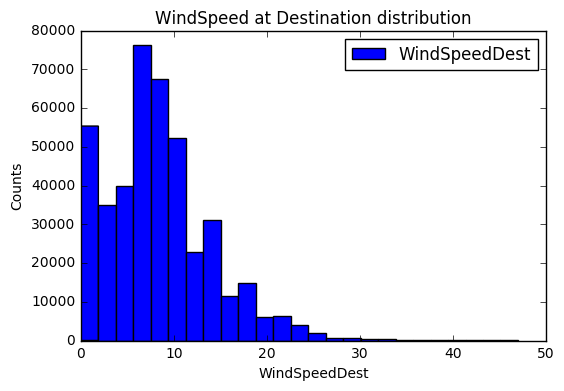

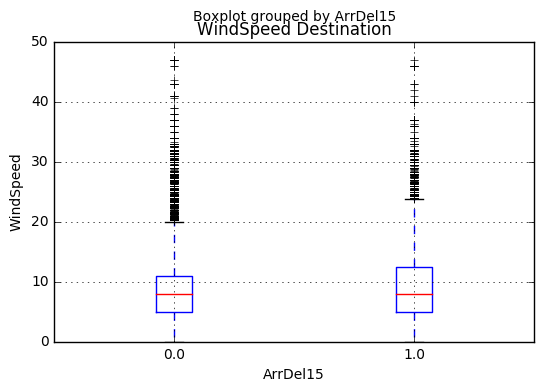

In [14]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
#%%local creates a pandas data-frame on the head node memory, from spark data-frame

ax1 = sqlResultsPD[['WindSpeedDest']].plot(kind='hist', bins=25, facecolor='blue')
ax1.set_title('WindSpeed at Destination distribution')
ax1.set_xlabel('WindSpeedDest'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()


ax2 = sqlResultsPD.boxplot(column=['WindSpeedDest'], by=['ArrDel15'])
ax2.set_title('WindSpeed Destination')
ax2.set_xlabel('ArrDel15'); ax2.set_ylabel('WindSpeed');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

#### Relative Humidity Plots (at origin airport)

In [15]:
%%sql -q -o sqlResultsPD -m sample -r 0.5 -n -1
SELECT ArrDel15, RelativeHumidityOrigin FROM plots

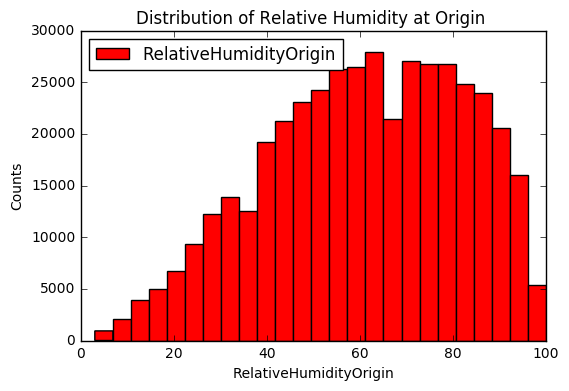

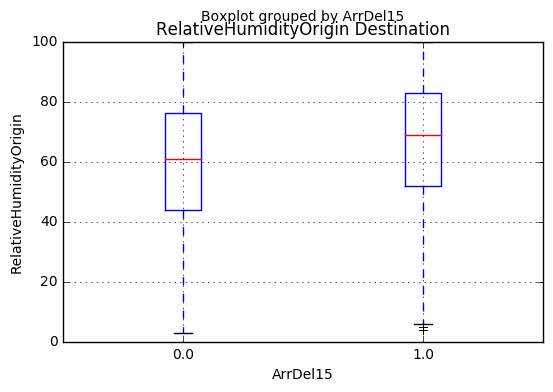

In [16]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
#%%local creates a pandas data-frame on the head node memory, from spark data-frame

#histogram
ax1 = sqlResultsPD[['RelativeHumidityOrigin']].plot(kind='hist', bins=25, facecolor='red')
ax1.set_title('Distribution of Relative Humidity at Origin ')
ax1.set_xlabel('RelativeHumidityOrigin'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()
#boxplot
ax2 = sqlResultsPD.boxplot(column=['RelativeHumidityOrigin'], by=['ArrDel15'])
ax2.set_title('RelativeHumidityOrigin Destination')
ax2.set_xlabel('ArrDel15'); ax2.set_ylabel('RelativeHumidityOrigin');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

####  Dewpoint at Destination BoxPlot

In [17]:
%%sql -q -o sqlResultsPD -m sample -r 0.5 -n -1
SELECT ArrDel15, DewPointCelsiusDest FROM plots

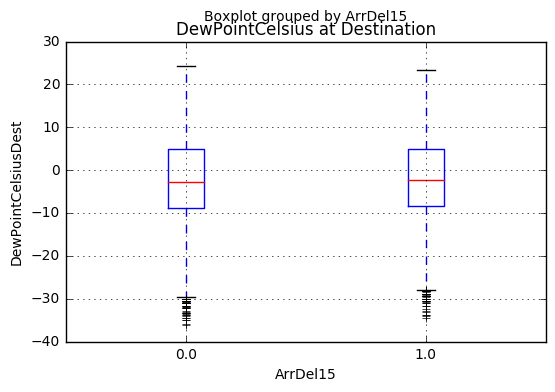

In [18]:
%%local
#boxplot
ax2 = sqlResultsPD.boxplot(column=['DewPointCelsiusDest'], by=['ArrDel15'])
ax2.set_title('DewPointCelsius at Destination')
ax2.set_xlabel('ArrDel15'); ax2.set_ylabel('DewPointCelsiusDest');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

#### AltimeterDest Plot

In [19]:
%%sql -q -o sqlResultsPD -m sample -r 0.5 -n -1
SELECT ArrDel15, AltimeterDest FROM plots

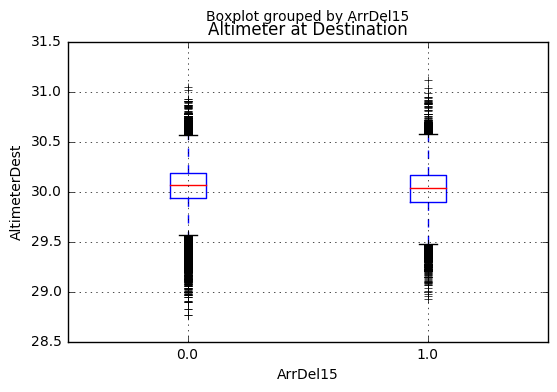

In [20]:
%%local
#boxplot
ax2 = sqlResultsPD.boxplot(column=['AltimeterDest'], by=['ArrDel15'])
ax2.set_title('Altimeter at Destination')
ax2.set_xlabel('ArrDel15'); ax2.set_ylabel('AltimeterDest');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

In the above plots we explore the relationship of the Binary variable ArrDel15 with respect to Windspeed,Altimeter Relative Humidity and Dew Point Celcius, at origin and destination airports. We see that humidity and windspeed have a linear realtionship to delays, that is, higher humidity and windspeed leads to more delays. However this is not the case for dewpoint celsius, and the inverse is true. Not all features are visualised.


----------------------------------
### 4.2 Feature engineering, transformation and data preparation for modeling

Split data into train/testv(75-25). Training fraction will be used to create model, and testing fraction will be used to evaluate model.

In [21]:
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;
trainPartition, testPartition = joined.randomSplit([trainingFraction, testingFraction], seed=seed);

# cache dataframes in memory
trainPartition.persist(); trainPartition.count()
testPartition.persist(); testPartition.count()

trainPartition.createOrReplaceTempView("TrainPartition")
testPartition.createOrReplaceTempView("TestPartition")

Filter out null values, and filter test data by categories of features to ensure transformations trained on test data will fit the the test data

In [22]:

trainPartitionFilt = trainPartition.filter("ArrDel15 is not NULL and DayOfMonth is not NULL and DayOfWeek is not NULL \
                and Carrier is not NULL and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL ")
trainPartitionFilt.persist(); trainPartitionFilt.count()
trainPartitionFilt.show(1)
trainPartitionFilt.createOrReplaceTempView("TrainPartitionFilt")

testPartitionFilt = testPartition.filter("ArrDel15 is not NULL and DayOfMonth is not NULL and DayOfWeek is not NULL \
                and Carrier is not NULL and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL") \
                .filter("OriginAirportID IN (SELECT distinct OriginAirportID FROM TrainPartitionFilt) \
                    AND ORIGIN IN (SELECT distinct ORIGIN FROM TrainPartitionFilt) \
                    AND DestAirportID IN (SELECT distinct DestAirportID FROM TrainPartitionFilt) \
                    AND DEST IN (SELECT distinct DEST FROM TrainPartitionFilt) \
                    AND Carrier IN (SELECT distinct Carrier FROM TrainPartitionFilt) \
                    AND CRSDepTime IN (SELECT distinct CRSDepTime FROM TrainPartitionFilt) \
                    AND DayOfMonth in (SELECT distinct DayOfMonth FROM TrainPartitionFilt) \
                    AND DayOfWeek in (SELECT distinct DayOfWeek FROM TrainPartitionFilt)")
testPartitionFilt.persist(); testPartitionFilt.count()
testPartitionFilt.show(1)
testPartitionFilt.createOrReplaceTempView("TestPartitionFilt")

+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------------------+-------------+-------------+
|ArrDel15|Year|Month|DayOfMonth|DayOfWeek|Carrier|OriginAirportID|ORIGIN|DestAirportID|DEST|CRSDepTime|VisibilityOrigin|DryBulbCelsiusOrigin|DewPointCelsiusOrigin|RelativeHumidityOrigin|WindSpeedOrigin|AltimeterOrigin|VisibilityDest|DryBulbCelsiusDest|DewPointCelsiusDest|RelativeHumidityDest|WindSpeedDest|AltimeterDest|
+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------------------+-------------+-------------+
|     0.0|2011|    1|         1|  

## 5. Modelling

### 5.1 Indexing features using pipeline transformations

Spark MLib Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines. MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. The components of a pipeline include a transformer and an estimator. The transformer can includes feature transformers and learned models. A Transformer implements a method transform(), which converts one DataFrame into another, generally by appending one or more columns. An Estimator fits or trains on data by implementing a method fit(), which accepts a DataFrame and produces a Model, which is a Transformer.

For our models we use tranformation pipeline with 3 stages that are added to the training and testing set, that are String Indexer for the classification variable, A binarizer and a string indexer for the carrier variable. The threshold for the binarizer 0.5, which means that the models predictions for example logistic regression above 0.5 is considered as a delayed flight and 0 otherwise for the predictions.

StringIndexer encodes a string column of labels to a column of label indices. The indices are ordered by label frequencies. Binarization is the process of thresholding numerical features to binary features.

In [23]:
# Add some features to the training and test set
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, Bucketizer, Binarizer

sI0 = StringIndexer(inputCol = 'ArrDel15', outputCol = 'ArrDel15_ind'); 
bin0 = Binarizer(inputCol = 'ArrDel15_ind', outputCol = 'ArrDel15_bin', threshold = 0.5);
sI1 = StringIndexer(inputCol="Carrier", outputCol="Carrier_ind");
transformPipeline = Pipeline(stages=[sI0, bin0, sI1]);

transformedTrain = transformPipeline.fit(trainPartition).transform(trainPartitionFilt)
transformedTest = transformPipeline.fit(trainPartition).transform(testPartitionFilt)


transformedTrain.persist(); transformedTrain.count();
transformedTest.persist(); transformedTest.count();
transformedTrain.show(1)
transformedTest.show(1)

+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------------------+-------------+-------------+------------+------------+-----------+
|ArrDel15|Year|Month|DayOfMonth|DayOfWeek|Carrier|OriginAirportID|ORIGIN|DestAirportID|DEST|CRSDepTime|VisibilityOrigin|DryBulbCelsiusOrigin|DewPointCelsiusOrigin|RelativeHumidityOrigin|WindSpeedOrigin|AltimeterOrigin|VisibilityDest|DryBulbCelsiusDest|DewPointCelsiusDest|RelativeHumidityDest|WindSpeedDest|AltimeterDest|ArrDel15_ind|ArrDel15_bin|Carrier_ind|
+--------+----+-----+----------+---------+-------+---------------+------+-------------+----+----------+----------------+--------------------+---------------------+----------------------+---------------+---------------+--------------+------------------+-------------------+--------


----------------------------------
### 5.2 Regression Formula

#### Define the training formula and transformations that's to be applied to all training pipelines

In the following step we set up a regression formula that is applied on our models. The ArrDel15_ind varible is used as the classification variable which is regressed on the predictor variables. For example, y ~ a + b means model y ~ w0 + w1 * a + w2 * b where w0 is the intercept and w1, w2 are coefficients.
Some categorical features such as origin and destination airports have > 240 categories, which is why maxCategories is set to 250. The regFormula is added as the column features.

In [24]:
from pyspark.ml.feature import RFormula

#Regression formula
regFormula = RFormula(formula="ArrDel15_ind ~ \
                        DayOfMonth + DayOfWeek + Carrier_ind + OriginAirportID + DestAirportID + CRSDepTime \
                        + VisibilityOrigin + DryBulbCelsiusOrigin + DewPointCelsiusOrigin \
                        + RelativeHumidityOrigin + WindSpeedOrigin + AltimeterOrigin \
                        + VisibilityDest + DryBulbCelsiusDest + DewPointCelsiusDest \
                        + RelativeHumidityDest + WindSpeedDest + AltimeterDest");
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=250)

### 5.3 Modelling Methods

spark.mllib comes with a number of machine learning algorithms that can be used to learn from and make predictions on data. We use Logistic Regression, Gradient Boosting and Random Forest Methods for this classification problem. The models are compared using the BinaryClassificationMetrics library based on the ROC(Receiver Operating Characteristic) curves, for each of these models. 

For all models we see the how the computing speed changes with increase in compute power by increasing number of nodes. For Random Forest, we see how we can use Spark Mlib for parameter hyper tuning.

#### 5.3.1 Logistic Regression

Training logisitic regression model, and evaluate performance on test data. Logistic regression is a popular method to predict a categorical response by predicting the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression.

The table belows shows us how the model speed changes by scaling the worker nodes of the cluster on HDInsight.



| Cluster Setup               | Time Taken for 100 iterations Log.Regr.   |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,4 worker nodes|      388.74 seconds                                   |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,6 worker nodes|      197.37 seconds                                 |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,8 worker nodes|      147.43 seconds                                    |



In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve,auc
import time

t1 = time.time()
# define log regression model
lgr = LogisticRegression(featuresCol="indexedFeatures", maxIter=100, regParam=0.01, elasticNetParam=0.5)

## TRAINING PIPELINE: Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, lgr]).fit(transformedTrain)

## Evaluate model on test set
predictions = model.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd
predictions.select("label","probability").createOrReplaceTempView("tmp_results")

print(time.time() - t1)


metrics = BinaryClassificationMetrics(predictionAndLabels)
#Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


388.7470426559448
Area under ROC = 0.7200910446300455

#### 5.3.2 Gradient Boosting

Train Gradient Boosting Tree binary classification model, and evaluate performance on test data. Gradient Boosting produces a prediction model with ensemble of decision trees. The model is built in stage-wise fashion and it generalizes them by allowing optimization of an arbitrary differentiable loss function.Thus, they iteratively train decision trees in order to minimize a loss function.

The table belows shows us how the model speed changes by scaling the worker nodes of the cluster on HDInsight.



| Cluster Setup               | Time Taken for 50 iterations GBoosting    |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,4 worker nodes|     841.56 seconds                                    |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,6 worker nodes|     769.34 seconds                                      |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,8 worker nodes|     662.35 seconds                                      |


In [26]:
from pyspark.ml.regression import GBTRegressor

t1 = time.time()
## GBoosting define
gBT = GBTRegressor(featuresCol="indexedFeatures", maxIter=50, maxBins = 250)

## TRAINING PIPELINE: Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, gBT]).fit(transformedTrain)

## Evaluate model on test set
predictions = model.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd

print(time.time() - t1)

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

841.5669002532959
Area under ROC = 0.7551033469862032

#### 5.3.3 Random Forest

Train a random forest binary classification model using the Pipeline function, save, and evaluate on test data set.
Random forests like gradient boosting are also ensembles of decision trees. They combine many decision trees in order to reduce the risk of overfitting. Spark.ml implementation supports random forests for binary and multiclass classification and regression, using both continuous and categorical features.

We make use of Spark.Mlib Parameter Tuning function to tune the Random Forest Model by training a random forest model using 3 fold cross-validation using grid parameters for different number of decsision trees and depths.

The table belows shows us how the model speed changes by scaling the worker nodes of the cluster on HDInsight.


| Cluster Setup               | Time Taken for maxBins 250 for Random Forest   |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,4 worker nodes|     1782.73 seconds                                     |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,6 worker nodes|     1363.79 seconds                                  |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,8 worker nodes|     1280.93 seconds                                     |

In [27]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

t1 = time.time()
#define classifier
randForest = RandomForestClassifier(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, \
                                   maxDepth=6, maxBins=250)


# DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

# DEFINE PARAMETER GRID FOR RANDOM FOREST
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.maxDepth, [3, 5, 7]) \
    .build()

## define crossvalidation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=3)

## train model using Crossvalidation
cvModel = crossval.fit(transformedTrain)

## Evaluate model on test set
predictions = cvModel.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd

print(time.time() - t1)
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)


1782.7389588356018
Area under ROC = 0.7846627350163937

## 6. Conclusion

By comparing the ROC curves for each method, we see that the best performing model is Random Forest followed by Gradient Boosting and lastly Logistic Regression. There is a direct relationship between the number of worker nodes and the computing speed of each model. The increase in the number of nodes allows the computation of the file partitions in each node take pace on respective nodes which results in faster processing of the model fitting and training. The models are compared ny keeping the number of iterations constant, respectively for each model.



In the table below we analyse the total runtime of the whole notebook with respect to scaling the cluster.

| Cluster Setup               | Total Runtime of the Notebook   |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,4 worker nodes| 54 minutes 18 seconds                                     |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,6 worker nodes| 45 minutes 23 seconds                                      |
|-----------------------------|-------------------------------------------|
|D12 V2:2 head nodes,8 worker nodes|  32 minutes 14 seconds                                         |





## References

1. Apache. https://spark.apache.org/docs/latest/ml-pipeline.html. n.d. April 2018.
2. Microsoft . https://docs.microsoft.com/en-us/azure/machine-learning/service/overview-what-is-azure-ml. n.d. 21 April 2018.
3. Microsoft Azure. https://docs.microsoft.com/en-us/azure/hdinsight/hadoop/apache-hadoop-linux-tutorial-get-started. n.d. 10 April 2018.
4. spoddutur. https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html. n.d. 24 April 2018.
5. Fast.ai github repo link for DecisionTree from scratch https://github.com/fastai/fastai
6. Hastie, Trevor; Tibshirani, Robert; Friedman, Jerome (2008). The Elements of Statistical Learning (2nd ed.). Springer
7. Tutorials point. https://www.tutorialspoint.com/apache_spark/apache_spark_quick_guide.htm n.d April 2018
